In [1]:
import os
os.chdir('../src')
import yaml
import argparse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datasets import stellar_data
from datasets.stellar_data import make_graph_list_from_anndata, StellarDataloader
from datasets import data_utils

d:\dlls-pro\dlls-pro-venv\Lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] Nie można odnaleźć określonej procedury
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## Finding the distances threshold for the cell pairs within a sample
In the paper the distance threshold is chosen so that there are on average 5 vertices connected to each node. Given the cdf of the distances between cell pairs (with redundant info about distance of pairs) the cells $\mathcal{F}(d)$ the task is to choose $d$, such that
$$\frac{\mathcal{F}(d)\cdot n_{distances}}{n_{cells}}\approx 5 \rightarrow d \approx \mathcal{F}^{-1}\left(\frac{5\cdot n_{cells}}{n_{distances}}\right)$$
In the paper clustering bases sampling is used further limiting the number of neighbours in practice, but this is disregarded here.

In [4]:
all_distances = stellar_data.get_all_distances()

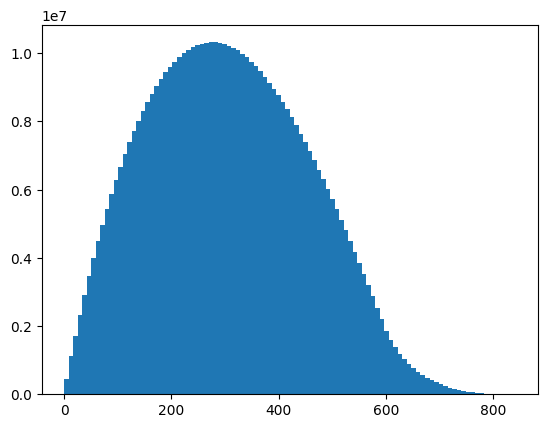

In [5]:
plt.hist(all_distances, bins=100)
plt.show()

In [12]:
n_cells = len(data_utils.load_full_anndata())
n_distances = len(all_distances)
p = 5 * n_cells / n_distances
print(f"The calculated quantile order equals {p}")

The calculated quantile order equals 0.002271199181869149


In [7]:
distance_threshold = np.quantile(all_distances, p)

In [8]:
print(f"The calculated distance threshold equals {distance_threshold}")

The calculated distance threshold equals 14.2844523820389


In [9]:
(all_distances < distance_threshold).sum() / n_cells

5.0

## Creating a dataset based on the configuration file

In [6]:
with open('config/stellar/standard.yaml', 'r') as file:
    cfg = argparse.Namespace(**yaml.safe_load(file))

print(cfg)

Namespace(device='cpu', distance_threshold=14.28, batch_size=1, lr=0.001, epochs=20, weight_decay=0, hid_dim=160, input_dim=40, num_classes=14, target_labels=['B', 'BnT', 'CD4', 'CD8', 'DC', 'HLADR', 'MacCD163', 'Mural', 'NK', 'Neutrophil', 'Treg', 'Tumor', 'pDC', 'plasma'], encoder_impl=0, classification_head_impl=0)


In [11]:
cfg.target_labels

['B',
 'BnT',
 'CD4',
 'CD8',
 'DC',
 'HLADR',
 'MacCD163',
 'Mural',
 'NK',
 'Neutrophil',
 'Treg',
 'Tumor',
 'pDC',
 'plasma']

In [3]:
anndata = data_utils.load_full_anndata(test=False)

In [7]:
label_encoder = LabelEncoder().fit(cfg.target_labels)

In [8]:
graph_list = stellar_data.make_graph_list_from_anndata(
    anndata=anndata,
    label_encoder=label_encoder,
    distance_threshold=14,
)

In [9]:
graph_list[0]

Data(x=[487, 40], edge_index=[2, 550], y=[487], cell_ids=[487])

### Creating dataloaders based on the created list of graphs

In [22]:
stellar_dataloader = StellarDataloader(graph_list, batch_size=cfg.batch_size, shuffle=True)

In [23]:
next(iter(stellar_dataloader))

DataBatch(x=[563, 40], edge_index=[2, 870], y=[563], cell_ids=[1], batch=[563], ptr=[2])